# Benchmark: PXD024043

This notebook contains code to benchmark the model on the [PXD024043 dataset](https://www.ebi.ac.uk/pride/archive/projects/PXD024043) - cell cycle proteomes. 
Four cell populations enriched in different cell cycle stages were produced from HeLa cells by drug treatment.
Here, we'll use the precusor dataset. Download the zip-file, "DIANN1.8_SingleCells_CellCycle.zip" and locate the file, "20210919_DIANN_SingleCellOutput.pr_matrix.tsv".

Let's start with the imports.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
import torch

from scp.models import PROTVI

import scvi

np.random.seed(0)
torch.manual_seed(0)
scvi.settings.seed = 0

np.random.seed(0)

/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
Global seed set to 0


Let's define the path to the data.

In [2]:
DATA_PATH = "../data/PXD024043/20210919_DIANN_SingleCellOutput.pr_matrix.tsv"

## Data loading

Let's load the data

In [3]:
data = pd.read_csv(DATA_PATH, sep="\t")

In [4]:
var_cols = [c for c in data.columns if "D:\\" not in c]
vars = data[var_cols]

data.drop(var_cols, axis=1, inplace=True)

data = data.T
data = np.log(data + 1)

obs_names = [filename.split("\\")[-1] for filename in data.index.copy()]
data.index = obs_names

In [5]:
obs_new = [obs.replace("-", "_").replace("SA_ADB", "SA-ADB") for obs in obs_names]
annotations = [obs.split("_") for obs in obs_new]

dates = [obs[0] for obs in annotations]
unknown1 = [obs[3] for obs in annotations]
n_cells = [obs[4] for obs in annotations]
species = [obs[5] for obs in annotations]
unknown2 = [obs[6] for obs in annotations]
unknown3 = [obs[7] for obs in annotations]
unknown4 = [obs[8] for obs in annotations]
position = [obs[9] for obs in annotations]
replicate = [obs[10] for obs in annotations]
file_index = [obs[11][:-2] for obs in annotations]

condition = [
    "G1" if "G1" in unk2
    else "G1-S" if "TB" == unk2
    else "G2" if "G2" == unk2
    else "G1-M" if "NB" == unk2
    else "UB_Passage01" if ("UB" == unk2) and ("20201010" == date)
    else "UB_Passage02_Plate01" if ("UB" == unk2) and (int(file_index) < 5050)
    else "UB_Passage02_Plate02"
    for unk2, file_index, date in zip(unknown2, file_index, dates)
]

cell_cycle_stage = [
    "G1" if "G1" == name
    else "G1-S" if "TB" == name
    else "G2" if "G2" == name
    else "G2-M" if "NB" == name
    else "other"
    for name in unknown2
]

In [6]:
obs = pd.DataFrame(
    {
        "date": dates,
        "unknown1": unknown1,
        "n_cells": n_cells,
        "species": species,
        "unknown2": unknown2,
        "unknown3": unknown3,
        "unknown4": unknown4,
        "position": position,
        "replicate": replicate,
        "file_index": file_index,
        "condition": condition,
        "cell_cycle_stage": cell_cycle_stage,
    },

    index=obs_names,
)

adata = sc.AnnData(X=data, var=vars, obs=obs)

/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [7]:
adata

AnnData object with n_obs × n_vars = 434 × 10606
    obs: 'date', 'unknown1', 'n_cells', 'species', 'unknown2', 'unknown3', 'unknown4', 'position', 'replicate', 'file_index', 'condition', 'cell_cycle_stage'
    var: 'Protein.Group', 'Protein.Ids', 'Protein.Names', 'Genes', 'First.Protein.Description', 'Proteotypic', 'Stripped.Sequence', 'Modified.Sequence', 'Precursor.Charge', 'Precursor.Id'

## Data Exploration

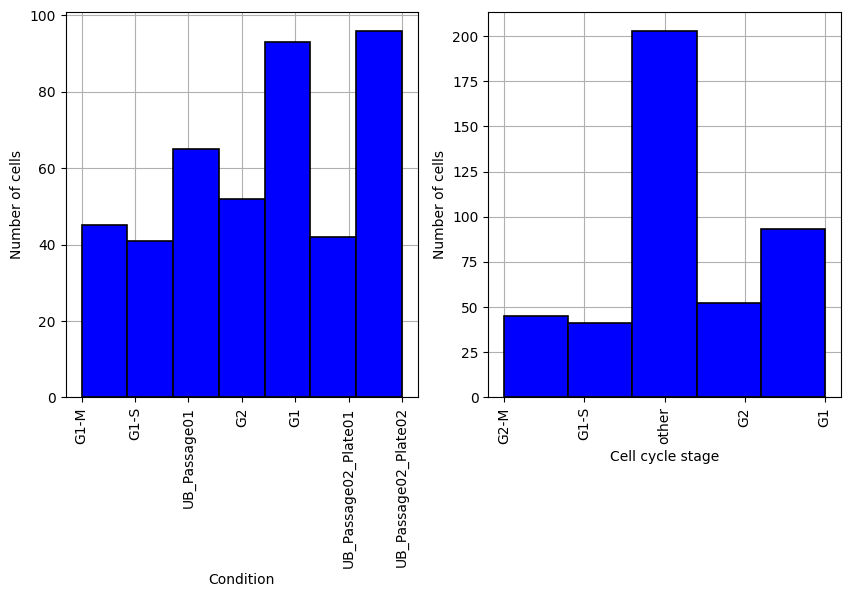

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

ax = axes[0]
ax.hist(adata.obs["condition"], bins=len(adata.obs["condition"].unique()), color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Condition")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

ax = axes[1]
ax.hist(adata.obs["cell_cycle_stage"], bins=len(adata.obs["cell_cycle_stage"].unique()), color="blue", edgecolor="black", linewidth=1.2)
ax.set_xlabel("Cell cycle stage")
ax.set_ylabel("Number of cells")
ax.grid(True)
ax.set_axisbelow(True)

for tick in ax.get_xticklabels():
    tick.set_rotation(90)

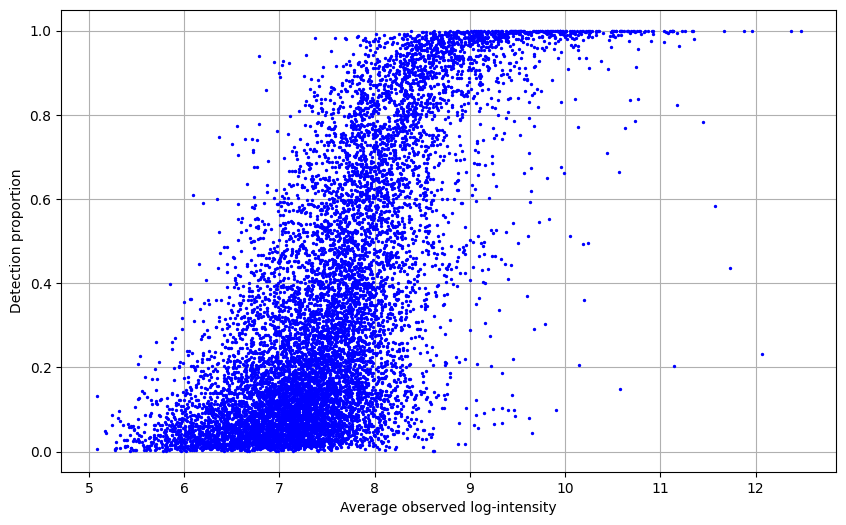

In [9]:
X_raw = adata.X

avg_protein_intensities = np.nanmean(X_raw, axis=0)
obs_detection_proportion = 1 - np.mean(np.isnan(X_raw), axis=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(avg_protein_intensities, obs_detection_proportion, color="blue", s=2)
ax.set_xlabel("Average observed log-intensity")
ax.set_ylabel("Detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

## Modelling

In the followng section, we use the following naming convension:
- observed intensity: non-NaN intensity in the dataset.
- present intensity: intensity imputed by PROTVI, which also has a non-NaN entry in the dataset.
- missing intensity: intensity imputed by PROTVI, which also has a NaN entry in the dataset.

Let's now model the data.

In [10]:
#sc.pp.filter_cells(adata, min_genes=600)
#sc.pp.filter_genes(adata, min_cells=0.15 * adata.shape[0])

In [11]:
adata.layers["missing_as_nan"] = adata.X.copy()

adata.X[np.isnan(adata.X)] = 0
adata.layers["missing_as_zero"] = adata.X.copy()

In [12]:
PROTVI.setup_anndata(adata, layer="missing_as_zero")

model = PROTVI(adata, log_variational=False, n_latent=16)
#model.view_anndata_setup()

In [13]:
model.train(max_epochs=60)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 60/60: 100%|██████████| 60/60 [00:14<00:00,  4.56it/s, v_num=1, train_loss_step=1.89e+4, train_loss_epoch=1.64e+4]

`Trainer.fit` stopped: `max_epochs=60` reached.


Epoch 60/60: 100%|██████████| 60/60 [00:14<00:00,  4.13it/s, v_num=1, train_loss_step=1.89e+4, train_loss_epoch=1.64e+4]


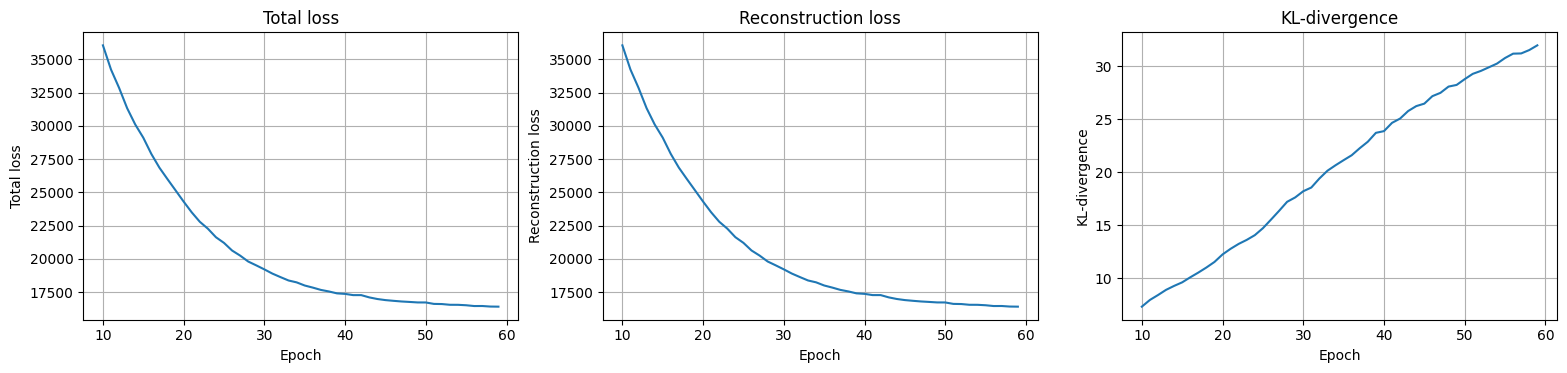

In [14]:
N_skip = 10

fig, axes = plt.subplots(figsize=(16, 4), ncols=3, nrows=1)
fig.tight_layout(pad=3)

ax = axes[0]
ax.plot(model.history["train_loss_epoch"].iloc[N_skip:])
ax.set_xlabel("Epoch")
ax.set_ylabel("Total loss")
ax.set_title("Total loss")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.plot(model.history["reconstruction_loss_train"].iloc[N_skip:])
ax.set_xlabel("Epoch")
ax.set_ylabel("Reconstruction loss")
ax.set_title("Reconstruction loss")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
ax.plot(model.history["kl_local_train"].iloc[N_skip:])
ax.set_xlabel("Epoch")
ax.set_ylabel("KL-divergence")
ax.set_title("KL-divergence")
ax.grid(True)
ax.set_axisbelow(True)

Let's look at the latent space.

In [15]:
latent = model.get_latent_representation()
adata.obsm["latent"] = latent

/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/rasmus/anaconda3/envs/scp/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: 

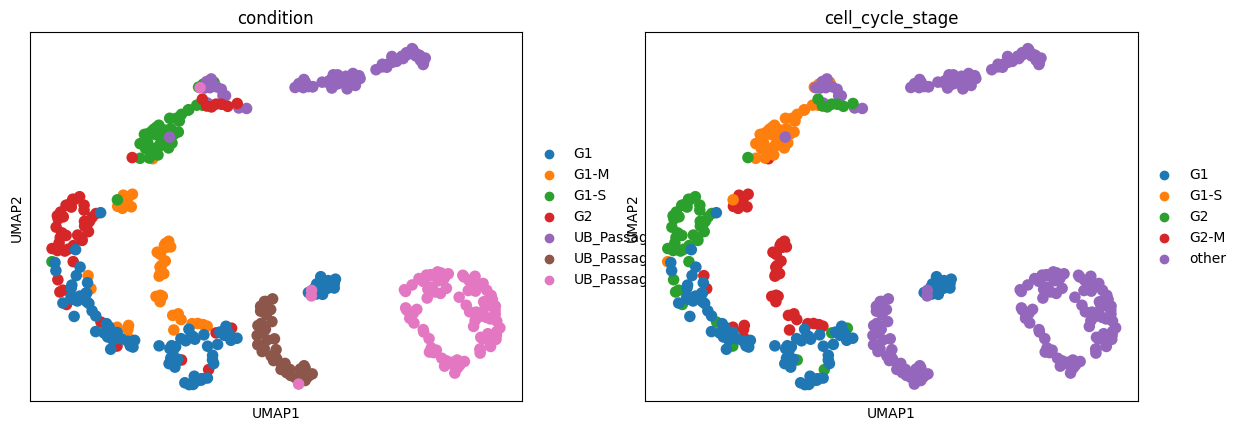

In [16]:
sc.pp.neighbors(adata, use_rep="latent")
sc.tl.umap(adata)

sc.pl.umap(
    adata, 
    color=["condition", "cell_cycle_stage"], 
    vmin="p01", vmax="p99",
    ncols=2,
)

Let's look at the predicted detection probability for each protein, and compare it to the actual missingness.

In [17]:
dataset = model.adata_manager.create_torch_dataset()

data = {}
for key, value in dataset.data.items():
    if isinstance(value, np.ndarray):
        data[key] = torch.from_numpy(value).to(torch.float32)
    elif isinstance(value, pd.DataFrame):
        data[key] = torch.from_numpy(value.values).to(torch.float32)
    else:
        raise ValueError(f"Unexpected data type {type(value)}")

with torch.no_grad():
    inference_output, generative_output, loss = model.module(data)

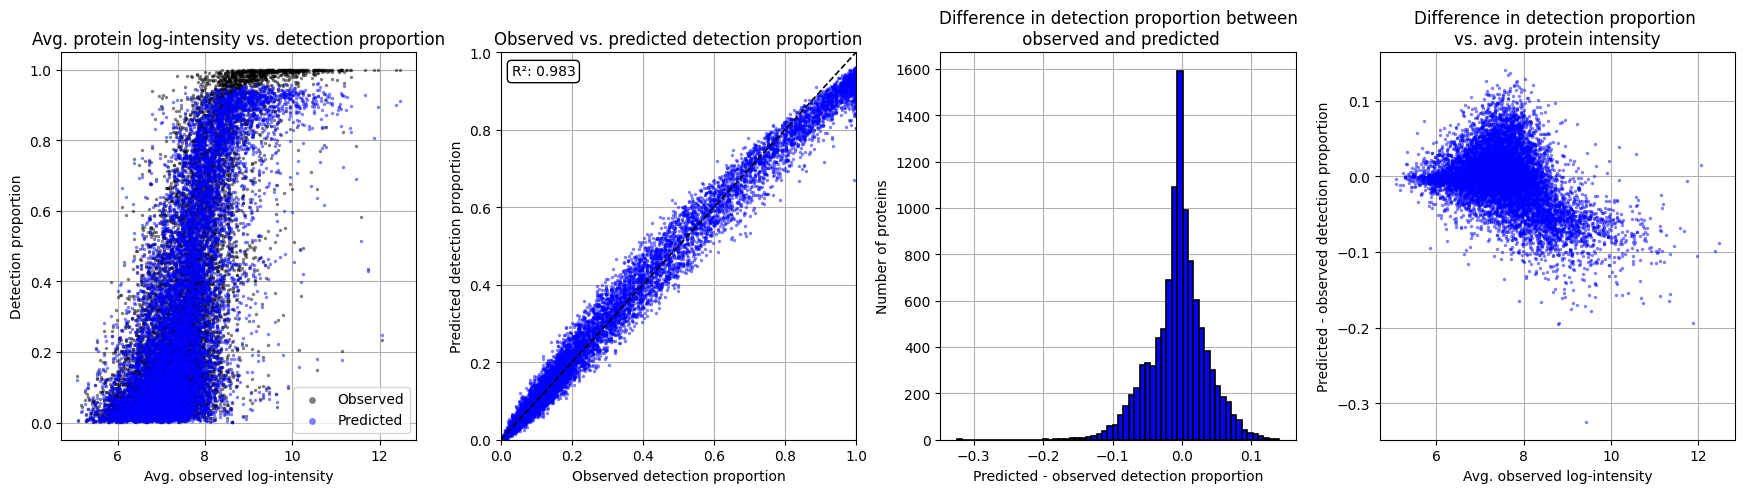

In [18]:
X_raw = adata.layers["missing_as_nan"]

avg_protein_intensities = np.nanmean(X_raw, axis=0)
obs_detection_proportion = 1 - np.mean(np.isnan(X_raw), axis=0)

pred_prob_detection = generative_output["prob_detection"].cpu().numpy()
pred_detection_proportion = pred_prob_detection.mean(axis=0)

fig, axes = plt.subplots(figsize=(18, 5), ncols=4)
fig.tight_layout(pad=3)

ax = axes[0]
ax.scatter(avg_protein_intensities, obs_detection_proportion, color="black", edgecolor="black", linewidth=0, s=6, alpha=.5, label="Observed")
ax.scatter(avg_protein_intensities, pred_detection_proportion, color="blue", edgecolor="black", linewidth=0, s=6, alpha=.5, label="Predicted")
ax.set_xlabel("Avg. observed log-intensity")
ax.set_ylabel("Detection proportion")
ax.set_title("Avg. protein log-intensity vs. detection proportion")
ax.legend()
ax.grid(True)
ax.set_axisbelow(True)
ax.legend(markerscale=2)

ax = axes[1]
SS_res = np.sum((obs_detection_proportion - pred_detection_proportion) ** 2)
SS_tot = np.sum((obs_detection_proportion - np.mean(obs_detection_proportion)) ** 2)
r_squared = 1 - (SS_res / SS_tot)
ax.text(0.03, 0.94, f"R²: {r_squared:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"))
#pearson = pearsonr(obs_detection_proportion, pred_detection_proportion)
#ax.text(0.03, 0.90, f"Pearson corr.\n{pearson[0]:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"))
ax.scatter(obs_detection_proportion, pred_detection_proportion, color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.plot([0, 1], [0, 1], color="black", linewidth=1.2, linestyle="--")
ax.set(xlim=[0, 1], ylim=[0, 1])
ax.set_xlabel("Observed detection proportion")
ax.set_ylabel("Predicted detection proportion")
ax.set_title("Observed vs. predicted detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
diff = pred_detection_proportion - obs_detection_proportion
ax.hist(diff, bins=60, color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_xlabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion between\n observed and predicted")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[3]
ax.scatter(avg_protein_intensities, diff, color="blue", edgecolor="black", linewidth=0, s=6, alpha=.5)
ax.set_xlabel("Avg. observed log-intensity")
ax.set_ylabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion \nvs. avg. protein intensity")
ax.grid(True)
ax.set_axisbelow(True)

Let's compare the "protein intensities" predicted by the model - specifically between the missing and present intensity entries in the original dataset for each protein.m

In [19]:
mu = generative_output["px_mean"].cpu().numpy()

mu_present = mu.copy()
mu_present[np.isnan(X_raw)] = np.nan

mu_missing = mu.copy()
mu_missing[~np.isnan(X_raw)] = np.nan

In [20]:
print("Total averages:")
print(f"  Mean intensity (mu) of missing intensities: {np.nanmean(mu_missing):.2f}")
print(f"  Mean intensity (mu) of present intensities: {np.nanmean(mu_present):.2f}")

Total averages:
  Mean intensity (mu) of missing intensities: 1.51
  Mean intensity (mu) of present intensities: -0.52


Let's look at each protein individually. We'll first filter out proteins which do not contain any missing intensities. Note, the intensities are log intensities!

In [21]:
limited_coverage_proteins = np.isnan(mu_present).any(axis=0)
mu_present = mu_present[:, limited_coverage_proteins]
mu_missing = mu_missing[:, limited_coverage_proteins]

missing_intensity = np.nanmean(mu_missing, axis=0)
present_intensity = np.nanmean(mu_present, axis=0)

In [22]:
print("Protein averages:")
print(f"  Mean intensity (mu) of missing intensities: {np.mean(missing_intensity):.2f}")
print(f"  Mean intensity (mu) of present intensities: {np.mean(present_intensity):.2f}")

Protein averages:
  Mean intensity (mu) of missing intensities: 1.10
  Mean intensity (mu) of present intensities: 0.14


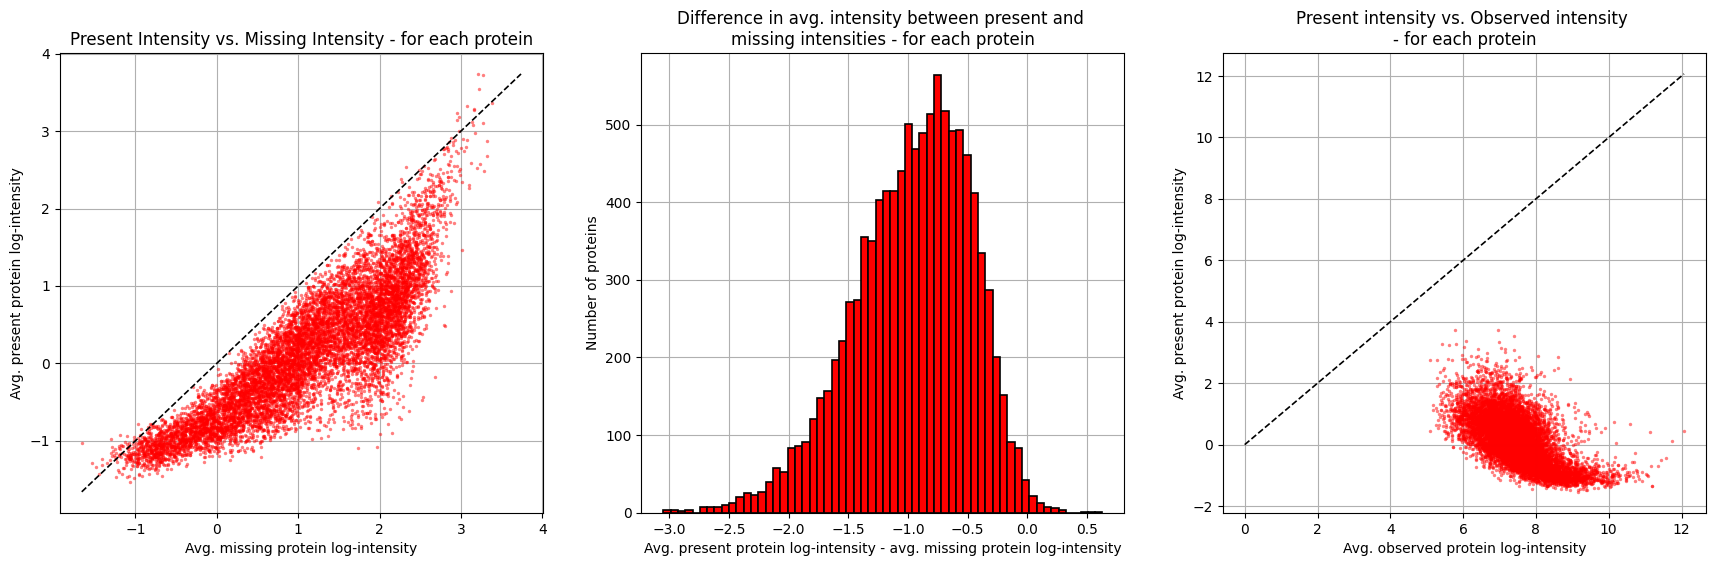

In [23]:
fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
fig.tight_layout(pad=4)

ax = axes[0]
min_v = min(present_intensity.min(), missing_intensity.min())
max_v = max(present_intensity.max(), missing_intensity.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--")
ax.scatter(missing_intensity, present_intensity, color="red", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_xlabel("Avg. missing protein log-intensity")
ax.set_ylabel("Avg. present protein log-intensity")
ax.set_title("Present Intensity vs. Missing Intensity - for each protein")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
difference = present_intensity - missing_intensity
ax.hist(difference, bins=60, color="red", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_xlabel("Avg. present protein log-intensity - avg. missing protein log-intensity")
ax.set_title("Difference in avg. intensity between present and \nmissing intensities - for each protein")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
observed_intensity = np.nanmean(X_raw, axis=0)
observed_intensity = observed_intensity[limited_coverage_proteins]
ax.plot([0, observed_intensity.max()], [0, observed_intensity.max()], color="black", linewidth=1.2, linestyle="--")
ax.scatter(observed_intensity, present_intensity, color="red", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.set_xlabel("Avg. observed protein log-intensity")
ax.set_ylabel("Avg. present protein log-intensity")
ax.set_title("Present intensity vs. Observed intensity \n- for each protein")
ax.grid(True)
ax.set_axisbelow(True)

## protDP - comparison

In [24]:
%%capture
import anndata2ri
anndata2ri.activate()

import rpy2.robjects as robjects
%load_ext rpy2.ipython

In [25]:
%%R -i adata
library(protDP)

X <- assay(adata, "missing_as_nan")
dpcfit <- dpc(X)

In [26]:
dpc_result = robjects.r("dpcfit")

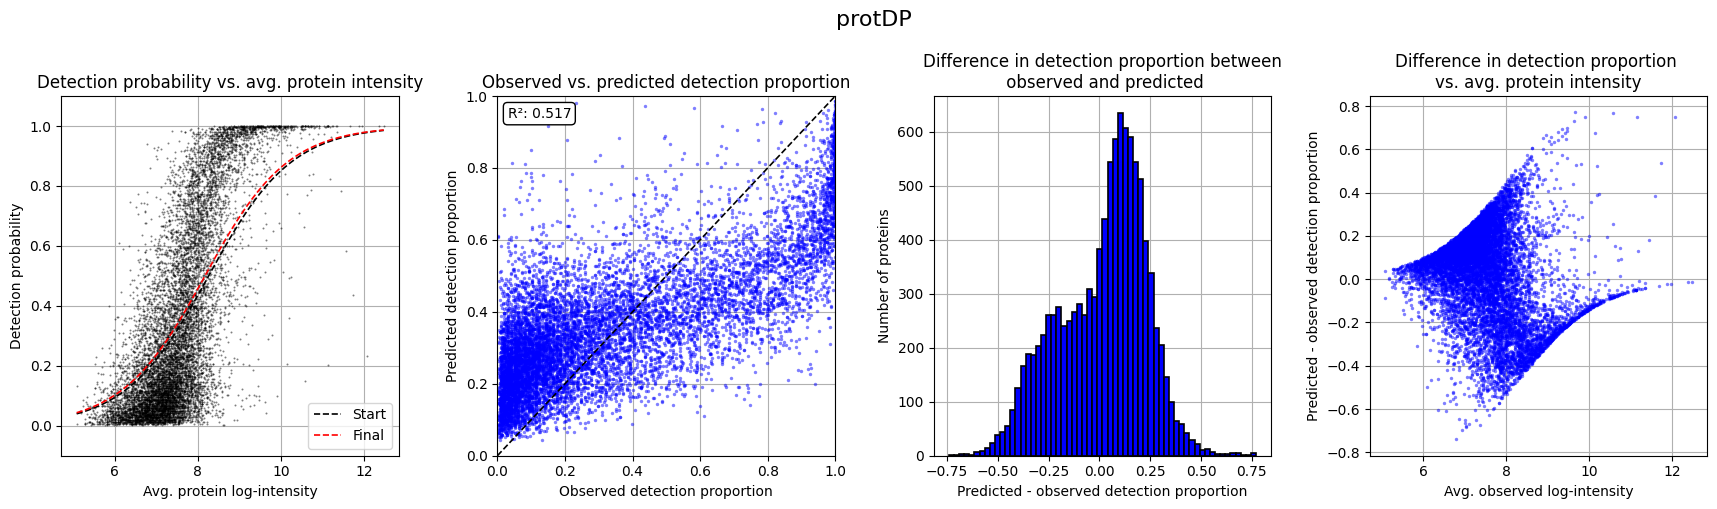

In [27]:
beta = dpc_result["beta"]
beta_start = dpc_result["betaStart"]

sigmoid = lambda x: 1 / (1 + np.exp(-x))

fig, axes = plt.subplots(figsize=(18, 5), ncols=4)
fig.tight_layout(pad=4)
fig.suptitle("protDP", fontsize=16, y=1.05)

ax = axes[0]
min_intensity = np.nanmin(avg_protein_intensities)
max_intensity = np.nanmax(avg_protein_intensities)
x = np.linspace(min_intensity, max_intensity, 100)
y1 = sigmoid(beta_start[0] + beta_start[1] * x)
y2 = sigmoid(beta[0] + beta[1] * x)
ax.plot(x, y1, color="black", linewidth=1.2, linestyle="--", label="Start")
ax.plot(x, y2, color="red", linewidth=1.2, linestyle="--", label="Final")
ax.scatter(avg_protein_intensities, obs_detection_proportion, color="black", linewidth=0, s=2, alpha=0.5)
ax.set_xlabel("Avg. protein log-intensity")
ax.set_ylabel("Detection probability")
ax.set_title("Detection probability vs. avg. protein intensity")
ax.set_ylim([-0.1, 1.1])
ax.grid(True)
ax.legend()
ax.set_axisbelow(True)

ax = axes[1]
dpc_detection_prop = sigmoid(beta[0] + beta[1] * avg_protein_intensities)
SS_res = np.sum((obs_detection_proportion - dpc_detection_prop) ** 2)
SS_tot = np.sum((obs_detection_proportion - np.mean(obs_detection_proportion)) ** 2)
r_squared = 1 - (SS_res / SS_tot)
ax.text(0.03, 0.94, f"R²: {r_squared:.3f}", fontsize=10, bbox=dict(facecolor="white", edgecolor="black", boxstyle="round"))
ax.scatter(obs_detection_proportion, dpc_detection_prop, color="blue", edgecolor="black", linewidth=0, s=6, alpha=0.5)
ax.plot([0, 1], [0, 1], color="black", linewidth=1.2, linestyle="--")
ax.set(xlim=[0, 1], ylim=[0, 1])
ax.set_xlabel("Observed detection proportion")
ax.set_ylabel("Predicted detection proportion")
ax.set_title("Observed vs. predicted detection proportion")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
diff = dpc_detection_prop - obs_detection_proportion
ax.hist(diff, bins=60, color="blue", edgecolor="black", linewidth=1.2)
ax.set_ylabel("Number of proteins")
ax.set_xlabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion between\n observed and predicted")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[3]
ax.scatter(avg_protein_intensities, diff, color="blue", edgecolor="black", linewidth=0, s=6, alpha=.5)
ax.set_xlabel("Avg. observed log-intensity")
ax.set_ylabel("Predicted - observed detection proportion")
ax.set_title("Difference in detection proportion \nvs. avg. protein intensity")
ax.grid(True)
ax.set_axisbelow(True)

Let's compare the results of the two methods:

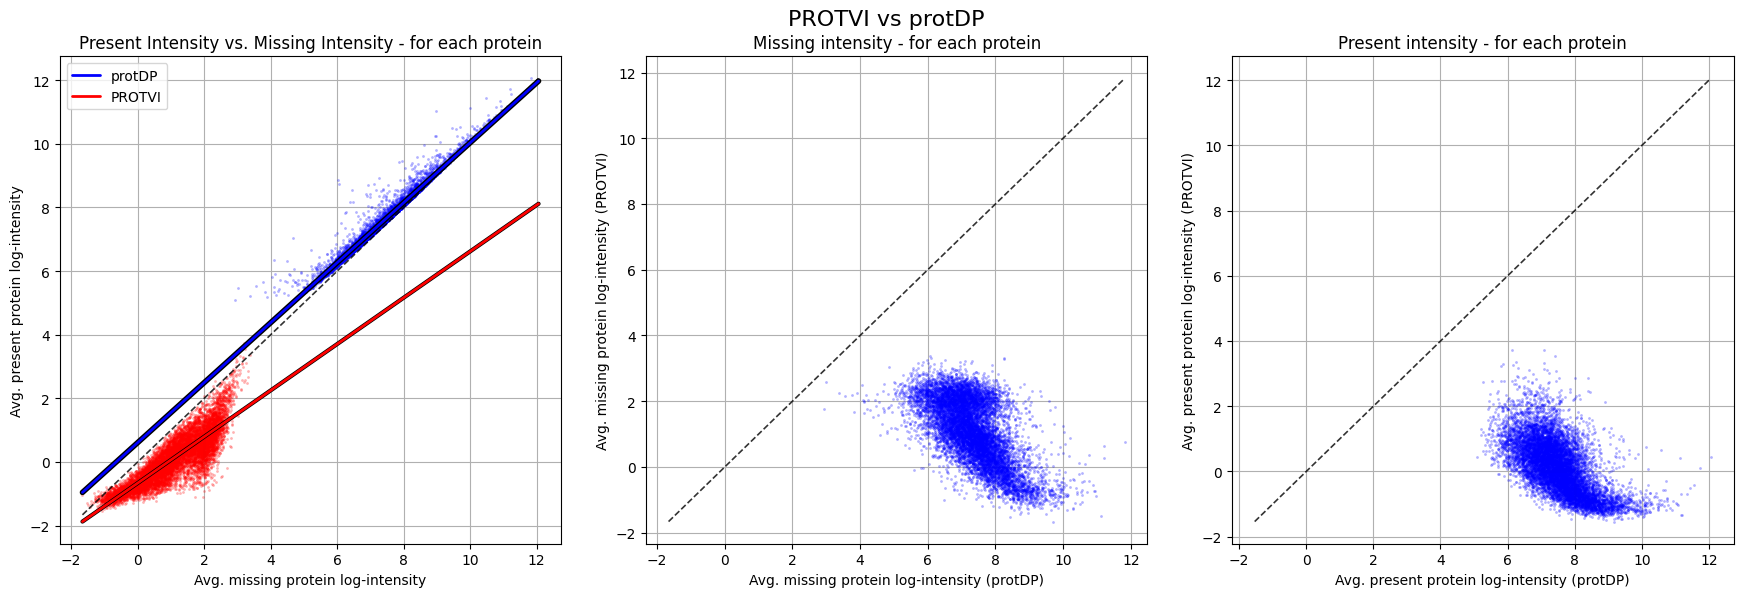

In [28]:
dpc_mu_miss = dpc_result["mu_mis"][limited_coverage_proteins]
dpc_mu_obs = dpc_result["mu_obs"][limited_coverage_proteins]

from sklearn.linear_model import LinearRegression
lm = LinearRegression()

fig, axes = plt.subplots(figsize=(18, 6), ncols=3)
fig.tight_layout(pad=3)
fig.suptitle("PROTVI vs protDP", fontsize=16, y=1)

ax = axes[0]
ax.scatter(missing_intensity, present_intensity, color="red", edgecolor="black", linewidth=0, s=4, alpha=.3)
ax.scatter(dpc_mu_miss, dpc_mu_obs, color="blue", edgecolor="purple", linewidth=0, s=4, alpha=.3)
min_v = min(present_intensity.min(), missing_intensity.min(), dpc_mu_miss.min(), dpc_mu_obs.min())
max_v = max(present_intensity.max(), missing_intensity.max(), dpc_mu_miss.max(), dpc_mu_obs.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--", alpha=.8)

lm.fit(dpc_mu_miss.reshape(-1, 1), dpc_mu_obs.reshape(-1, 1))
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="black", linewidth=4, linestyle="-", solid_capstyle="round",)
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="blue", linewidth=2, linestyle="-", solid_capstyle="round", label="protDP")

lm.fit(missing_intensity.reshape(-1, 1), present_intensity.reshape(-1, 1))
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="black", linewidth=3, linestyle="-", solid_capstyle="round")
ax.plot([min_v, max_v], [lm.intercept_[0] + lm.coef_[0] * min_v, lm.intercept_[0] + lm.coef_[0] * max_v], color="red", linewidth=2, linestyle="-", solid_capstyle="round", label="PROTVI")

ax.set_xlabel("Avg. missing protein log-intensity")
ax.set_ylabel("Avg. present protein log-intensity")
ax.set_title("Present Intensity vs. Missing Intensity - for each protein")
ax.legend(markerscale=2)
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[1]
ax.scatter(dpc_mu_miss, missing_intensity, color="blue", edgecolor="purple", linewidth=0, s=4, alpha=.3)
min_v = min(dpc_mu_miss.min(), missing_intensity.min())
max_v = max(dpc_mu_miss.max(), missing_intensity.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--", alpha=.8)
ax.set_xlabel("Avg. missing protein log-intensity (protDP)")
ax.set_ylabel("Avg. missing protein log-intensity (PROTVI)")
ax.set_title("Missing intensity - for each protein")
ax.grid(True)
ax.set_axisbelow(True)

ax = axes[2]
ax.scatter(dpc_mu_obs, present_intensity, color="blue", edgecolor="purple", linewidth=0, s=4, alpha=.3)
min_v = min(dpc_mu_obs.min(), present_intensity.min())
max_v = max(dpc_mu_obs.max(), present_intensity.max())
ax.plot([min_v, max_v], [min_v, max_v], color="black", linewidth=1.2, linestyle="--", alpha=.8)
ax.set_xlabel("Avg. present protein log-intensity (protDP)")
ax.set_ylabel("Avg. present protein log-intensity (PROTVI)")
ax.set_title("Present intensity - for each protein")
ax.grid(True)
ax.set_axisbelow(True)
